In [1]:
%matplotlib widget

import io
import configparser
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

from tathu.io import spatialite, pgis
from tathu import visualizer
from tathu.utils import extractPeriods, file2timestamp, array2raster, getGeoT, geo2grid

def bytea2nparray(bytea):
    """Converts Numpy Array from Postgres to python."""
    bdata = io.BytesIO(bytea)
    bdata.seek(0)
    return np.load(bdata)

In [2]:
# File paths
gld_path = "/home/camilacl/git/amazon-storms-aerosols/data/lightning/GLD_mod/"
radar_path = "/data2/GOAMAZON/radar/sipam_manaus/cptec_cappi/"
init_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/"
clusters_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/clusters_aero_systems_25km.csv"

# Load family
db = pgis.Loader(
    "localhost", "goamazon_geo", "postgres", "postgres", "systems_filtered"
)
# Get systems
names = db.loadNames()
# print(len(names))
# Get dates
dates = db.loadDates()
print(len(dates))

19199


In [3]:
# Get clusters data
clusters_25 = pd.read_csv(clusters_path).set_index('name')
cluster1_25 = clusters_25.loc[clusters_25['clust'] == 1].drop(columns=["clust", "max area"])
cluster2_25 = clusters_25.loc[clusters_25['clust'] == 2].drop(columns=["clust", "max area"])
cluster4_25 = clusters_25.loc[clusters_25['clust'] == 4].drop(columns=["clust", "max area"])
cluster5_25 = clusters_25.loc[clusters_25['clust'] == 5].drop(columns=["clust", "max area"])

In [4]:
cluster1_25.describe()

,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,max VIL,max VII,max VIWL,GLD strokes,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,total aerosols,ultrafine aerosols,total CCNs
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,54.036364,11.636364,10.318182,6.227273,0.255031,0.122450,0.177635,13.045455,2748.761872,-32.878984,76.305609,-3.602967,3.972350,2723.373212,987.434258,1159.630258
std,2.084545,2.172237,2.437531,1.066004,0.057221,0.077308,0.011735,22.712441,1509.603659,40.132566,6.373840,2.133954,0.383712,1271.860446,835.966885,604.699296
min,49.330000,7.000000,6.000000,4.000000,0.145503,0.000000,0.145503,0.000000,0.001041,-117.464745,61.802906,-6.395021,2.898325,610.819800,24.492088,272.756900
25%,52.542500,10.250000,9.000000,6.000000,0.217081,0.075223,0.173067,0.000000,1544.470325,-60.069769,74.398296,-5.095919,3.932626,1551.696900,297.645575,713.094475
50%,54.400000,11.500000,10.500000,6.000000,0.255835,0.116083,0.181478,1.500000,2433.011700,-6.072368,76.198540,-4.070611,4.075035,3005.389900,660.896610,1001.100850
75%,55.790000,13.000000,11.000000,7.000000,0.291471,0.167379,0.186020,13.750000,4030.286350,0.000000,79.750770,-1.666210,4.175682,3475.762200,1702.743775,1512.657250
max,56.859997,15.000000,15.000000,8.000000,0.368179,0.269407,0.192237,90.000000,5302.300300,0.000000,86.315575,2.091281,4.489130,5567.075000,2325.055200,2897.417700


In [5]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]

# -- Single params
query = (
    "SELECT DISTINCT ON (name) date_init25 FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
date_init = [q[0] for q in db.query(query)]

# -- Max, sum params
query = (
    "SELECT MAX(count) FROM systems_filtered"
    " GROUP BY name ORDER BY name ASC"
)
maxarea = [q[0] for q in db.query(query)]

# -- ALl clusters params
query = (
    "SELECT name, echotop_0, echotop_20, echotop_40, vil_kgm2, vii_kgm2, viwl_kgm2, gld_strmin FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
names_all = [q[0] for q in db.query(query)]
echotop0 = [q[1] for q in db.query(query)]
echotop20 = [q[2] for q in db.query(query)]
echotop40 = [q[3] for q in db.query(query)]
vil = [bytea2nparray(q[4]).max() / 10000 for q in db.query(query)]
vii = [bytea2nparray(q[5]).max() / 10000 for q in db.query(query)]
viwl = [bytea2nparray(q[6]).max() / 10000 for q in db.query(query)]
gld_strmin = [q[7] for q in db.query(query)]



In [6]:
systems = pd.DataFrame(
    {
        'name': names,
        'duration': [float(d) for d in durations],
        'date_init': date_init,
        'max_area': maxarea,
    }
).set_index('name')
systems['hour_init'] = systems.date_init.dt.hour
systems['month_init'] = systems.date_init.dt.month

systems = systems.reindex(
    columns=['duration', 'date_init', 'hour_init', 'month_init', 'max_area'])
systems.columns = [
    'duration', 
    'date_init', 
    'init hour', 
    'init month', 
    'max area', 
]

In [26]:
systems_all = pd.DataFrame(
    {
        'name': names_all,
        'echotop0': echotop0,
        'echotop20': echotop20,
        'echotop40': echotop40,
        'vil': vil,
        'vii': vii,
        'viwl': viwl,
        'gld_strmin': gld_strmin,
    }
).set_index('name')

systems_all['echotop0'] = np.where(systems_all['echotop0'] < 2, np.nan, systems_all['echotop0'])
systems_all['echotop20'] = np.where(systems_all['echotop20'] < 2, np.nan, systems_all['echotop20'])
systems_all['echotop40'] = np.where(systems_all['echotop40'] < 2, np.nan, systems_all['echotop40'])

In [28]:
clusters_25_all = systems_all[systems_all.index.isin(clusters_25.index)]
clusters_25_all.merge(clusters_25[['clust']], left_index=True, right_index=True).to_csv('/home/camilacl/git/amazon-storms-aerosols/data/general/clusters_all_25km.csv')

In [15]:
cluster5_25_all

,echotop0,echotop20,echotop40,vil,vii,viwl,gld_strmin
name,,,,,,,
0724dcee-5fc8-4bc5-b259-f0df4bedc458,14.0,12.0,6.0,0.2508,0.1810,0.2508,NaN
0724dcee-5fc8-4bc5-b259-f0df4bedc458,15.0,14.0,6.0,0.3312,0.2337,0.3312,0.333333
0724dcee-5fc8-4bc5-b259-f0df4bedc458,15.0,13.0,7.0,0.3315,0.2306,0.3315,-0.166667
0724dcee-5fc8-4bc5-b259-f0df4bedc458,15.0,15.0,6.0,0.3252,0.2294,0.3252,-0.083333
0724dcee-5fc8-4bc5-b259-f0df4bedc458,15.0,15.0,12.0,0.3383,0.2715,0.3383,0.666667
...,...,...,...,...,...,...,...
e92e6314-9935-422b-9f07-27db7a9543dc,14.0,12.0,7.0,0.3013,0.2038,0.3013,0.000000
e93c109c-7149-40b0-a9f0-6283aaeb5156,9.0,8.0,7.0,0.2034,0.0215,0.2034,NaN
e93c109c-7149-40b0-a9f0-6283aaeb5156,5.0,4.0,4.0,0.0936,0.0000,0.0936,0.416667


In [18]:
cluster1_25 = cluster1_25.join(systems.loc[cluster1_25.index.values], how="left")
cluster1_25 = cluster1_25[
    [
        'date_init', 
        'duration', 
        'sys duration', 
        'init hour', 
        'time of day',
        'init month', 
        'season', 
        'max area', 
        'area', 
        'lifespan', 
        'max reflectivity', 
        'reflectivity', 
        'max echotop 0 dBZ', 
        'max echotop 20 dBZ', 
        'max echotop 40 dBZ', 
        'max VIL', 
        'max VII', 
        'max VIWL',
        'GLD strokes',
        'electrical activity',
        'CAPE', 
        'CIN', 
        'bl relative humidity', 
        'v-wind shear', 
        'warm cloud depth',
        'total aerosols', 
        'ultrafine aerosols', 
        'total CCNs', 
    ]
]

In [19]:
systems.loc[cluster1_25.index.values]

,duration,date_init,init hour,init month,max area
name,,,,,
457531a7-9b7a-4afa-8e82-ce8fbcfc0831,60.0,2014-08-04 20:12:00,20.0,8.0,775.0
3c579c35-1bf2-4e72-b0b7-bfc9a7bf259e,132.0,2014-10-06 05:24:00,5.0,10.0,182.0
d6f9701e-5ebc-4bd8-990f-5702937553f6,12.0,2014-08-23 01:36:00,1.0,8.0,179.0
587d7e6f-1827-4478-9433-68707c3011c6,12.0,2014-08-12 07:36:00,7.0,8.0,235.0
399ec594-7f49-4228-b57c-7aab5374561f,36.0,NaT,NaN,NaN,620.0
971e3b71-d062-4ed2-bc43-e9bd16d535cb,0.0,2014-08-08 06:36:00,6.0,8.0,110.0
194735a6-c3af-4249-9053-2bbd33b9fc83,144.0,2014-12-30 19:36:00,19.0,12.0,374.0
0c1c27da-73ea-450c-bf6d-e2f1f3a33dd8,36.0,2014-08-13 19:48:00,19.0,8.0,270.0
31fac6af-7374-4ea4-bfd7-c4f076ef1714,144.0,NaT,NaN,NaN,321.0


In [20]:
cluster1_25.describe()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,max VIL,max VII,max VIWL,GLD strokes,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,total aerosols,ultrafine aerosols,total CCNs
count,22.000000,18.000000,18.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,74.181818,12.444444,8.388889,336.363636,54.036364,11.636364,10.318182,6.227273,0.255031,0.122450,0.177635,13.045455,2748.761872,-32.878984,76.305609,-3.602967,3.972350,2723.373212,987.434258,1159.630258
std,61.705627,7.350248,1.377931,203.925184,2.084545,2.172237,2.437531,1.066004,0.057221,0.077308,0.011735,22.712441,1509.603659,40.132566,6.373840,2.133954,0.383712,1271.860446,835.966885,604.699296
min,0.000000,1.000000,5.000000,110.000000,49.330000,7.000000,6.000000,4.000000,0.145503,0.000000,0.145503,0.000000,0.001041,-117.464745,61.802906,-6.395021,2.898325,610.819800,24.492088,272.756900
25%,27.000000,6.000000,8.000000,179.750000,52.542500,10.250000,9.000000,6.000000,0.217081,0.075223,0.173067,0.000000,1544.470325,-60.069769,74.398296,-5.095919,3.932626,1551.696900,297.645575,713.094475
50%,54.000000,15.000000,8.000000,271.500000,54.400000,11.500000,10.500000,6.000000,0.255835,0.116083,0.181478,1.500000,2433.011700,-6.072368,76.198540,-4.070611,4.075035,3005.389900,660.896610,1001.100850
75%,132.000000,19.000000,8.750000,402.500000,55.790000,13.000000,11.000000,7.000000,0.291471,0.167379,0.186020,13.750000,4030.286350,0.000000,79.750770,-1.666210,4.175682,3475.762200,1702.743775,1512.657250
max,192.000000,20.000000,12.000000,815.000000,56.859997,15.000000,15.000000,8.000000,0.368179,0.269407,0.192237,90.000000,5302.300300,0.000000,86.315575,2.091281,4.489130,5567.075000,2325.055200,2897.417700


In [21]:
cluster1_25.corr()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,max VIL,max VII,max VIWL,GLD strokes,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,total aerosols,ultrafine aerosols,total CCNs
duration,1.000000,0.016260,-0.013718,0.255238,-0.151602,0.018990,-0.206190,-0.025272,-0.082338,-0.023843,0.021818,-0.112608,0.164390,-0.058680,-0.059871,0.045524,0.271258,-0.047746,-0.003506,0.028644
init hour,0.016260,1.000000,0.196824,0.072804,0.154304,-0.172161,-0.350089,-0.309327,-0.231711,-0.259908,-0.274108,0.200407,0.458717,0.689399,-0.465897,-0.077694,-0.583836,-0.143833,0.225104,-0.279974
init month,-0.013718,0.196824,1.000000,-0.305570,-0.225526,0.308304,0.245719,0.018912,0.204984,0.279327,0.088587,-0.030859,0.311063,0.374280,-0.198452,-0.110283,-0.213230,-0.383648,-0.242089,-0.379151
max area,0.255238,0.072804,-0.305570,1.000000,0.363781,0.157153,0.179666,0.406385,0.232690,0.260102,0.001387,0.721997,-0.028770,-0.119007,0.148741,0.475568,-0.020607,-0.216191,-0.177646,-0.138212
max reflectivity,-0.151602,0.154304,-0.225526,0.363781,1.000000,-0.016396,0.054032,0.074107,0.051034,-0.000365,0.094657,0.272622,0.122804,-0.033160,0.108701,0.461291,-0.075844,-0.364187,-0.082190,-0.297679
max echotop 0 dBZ,0.018990,-0.172161,0.308304,0.157153,-0.016396,1.000000,0.904244,0.551498,0.928520,0.965024,0.748993,0.054401,-0.089136,-0.071722,-0.206276,0.252671,-0.160170,-0.197919,-0.245687,-0.027574
max echotop 20 dBZ,-0.206190,-0.350089,0.245719,0.179666,0.054032,0.904244,1.000000,0.648913,0.964726,0.956673,0.757075,0.204438,-0.208755,-0.113157,-0.050148,0.282542,-0.148934,-0.126481,-0.318153,0.049924
max echotop 40 dBZ,-0.025272,-0.309327,0.018912,0.406385,0.074107,0.551498,0.648913,1.000000,0.694209,0.657138,0.677756,0.333907,0.164240,0.075839,0.254554,0.307900,-0.039838,0.129370,-0.120961,0.325064
max VIL,-0.082338,-0.231711,0.204984,0.232690,0.051034,0.928520,0.964726,0.694209,1.000000,0.964397,0.837498,0.154715,-0.100728,-0.051204,-0.132751,0.317108,-0.193894,-0.097444,-0.269404,0.098118
max VII,-0.023843,-0.259908,0.279327,0.260102,-0.000365,0.965024,0.956673,0.657138,0.964397,1.000000,0.737223,0.226159,-0.114624,-0.071793,-0.160333,0.252841,-0.147803,-0.116666,-0.276144,0.057542


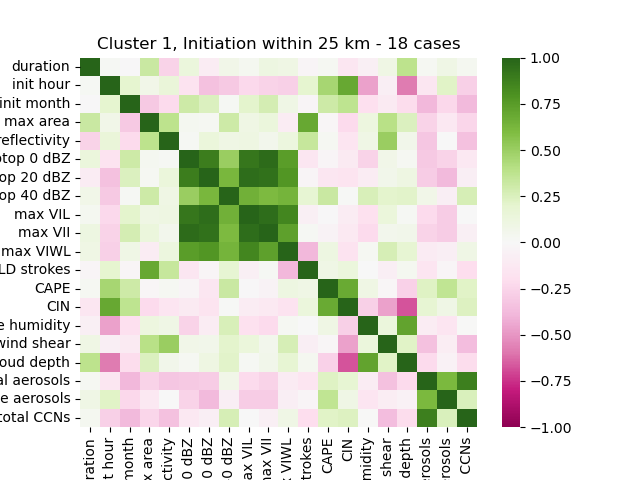

In [22]:
import seaborn as sns

plt.clf()
sns.heatmap(cluster1_25.dropna().corr(), vmin=-1, vmax=1, cmap='PiYG').set_title("Cluster 1, Initiation within 25 km - " + str(cluster1_25.dropna().shape[0]) + " cases")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_clust1_init25.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

In [23]:
cluster2_25 = cluster2_25.join(systems.loc[cluster2_25.index.values], how="left")
cluster2_25 = cluster2_25[
    [
        'date_init', 
        'duration', 
        'sys duration', 
        'init hour', 
        'time of day',
        'init month', 
        'season', 
        'max area', 
        'area', 
        'lifespan', 
        'max reflectivity', 
        'reflectivity', 
        'max echotop 0 dBZ', 
        'max echotop 20 dBZ', 
        'max echotop 40 dBZ', 
        'max VIL', 
        'max VII', 
        'max VIWL',
        'GLD strokes',
        'electrical activity',
        'CAPE', 
        'CIN', 
        'bl relative humidity', 
        'v-wind shear', 
        'warm cloud depth',
        'total aerosols', 
        'ultrafine aerosols', 
        'total CCNs', 
    ]
]

In [24]:
import seaborn as sns

plt.clf()
sns.heatmap(cluster2_25.dropna().corr(), vmin=-1, vmax=1, cmap='PiYG').set_title("Cluster 2, Initiation within 25 km - " + str(cluster2_25.dropna().shape[0]) + " cases")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_clust2_init25.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

In [25]:
cluster4_25 = cluster4_25.join(systems.loc[cluster4_25.index.values], how="left")
cluster4_25 = cluster4_25[
    [
        'date_init', 
        'duration', 
        'sys duration', 
        'init hour', 
        'time of day',
        'init month', 
        'season', 
        'max area', 
        'area', 
        'lifespan', 
        'max reflectivity', 
        'reflectivity', 
        'max echotop 0 dBZ', 
        'max echotop 20 dBZ', 
        'max echotop 40 dBZ', 
        'max VIL', 
        'max VII', 
        'max VIWL',
        'GLD strokes',
        'electrical activity',
        'CAPE', 
        'CIN', 
        'bl relative humidity', 
        'v-wind shear', 
        'warm cloud depth',
        'total aerosols', 
        'ultrafine aerosols', 
        'total CCNs', 
    ]
]

In [26]:
import seaborn as sns

plt.clf()
sns.heatmap(cluster4_25.dropna().corr(), vmin=-1, vmax=1, cmap='PiYG').set_title("Cluster 4, Initiation within 25 km - " + str(cluster4_25.dropna().shape[0]) + " cases")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_clust4_init25.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

In [27]:
cluster5_25 = cluster5_25.join(systems.loc[cluster5_25.index.values], how="left")
cluster5_25 = cluster5_25[
    [
        'date_init', 
        'duration', 
        'sys duration', 
        'init hour', 
        'time of day',
        'init month', 
        'season', 
        'max area', 
        'area', 
        'lifespan', 
        'max reflectivity', 
        'reflectivity', 
        'max echotop 0 dBZ', 
        'max echotop 20 dBZ', 
        'max echotop 40 dBZ', 
        'max VIL', 
        'max VII', 
        'max VIWL',
        'GLD strokes',
        'electrical activity',
        'CAPE', 
        'CIN', 
        'bl relative humidity', 
        'v-wind shear', 
        'warm cloud depth',
        'total aerosols', 
        'ultrafine aerosols', 
        'total CCNs', 
    ]
]

In [28]:
import seaborn as sns

plt.clf()
sns.heatmap(cluster5_25.dropna().corr(), vmin=-1, vmax=1, cmap='PiYG').set_title("Cluster 5, Initiation within 25 km - " + str(cluster5_25.dropna().shape[0]) + " cases")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_clust5_init25.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)